<a href="https://colab.research.google.com/github/Annie00000/Project/blob/main/1_9_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🚀 **最強 RCA 分析標準流程 (The Ultimate Workflow)**

針對半導體製程中這種 **「資料極端不均（長尾分佈）」、「類別數落差大（2 vs 100）」、且「樣本數有限（N=2000）」** 的複雜 RCA 情境，我為你總結出一套最穩健、最具實務公信力的分析標準流程（Best Practice）。

這套方法能自動平衡「碎類別」與「大類別」的競爭，確保找出的根因機台是真實且具信賴度的。

---


### 第一步：預處理——排除「雜訊干擾」

針對那種 20 群裡有一堆佔比極小的機台（長尾），必須先進行 **「低頻過濾」**。

* **做法：** 凡是樣本佔比小於 **1%** (例如 2000 筆中不到 20 筆) 的類別，統統歸類為 `'Other_Tools'`。
* **理由：** 避免極小樣本產生的隨機波動（如某台只做 2 片剛好都壞）被誤判為強相關。

### 第二步：計算「三維度」核心指標

我們不再只依賴單一分數，而是由三個不同維度的統計量組成：

1. **數值偏移解釋力 ($\omega^2$)**：
* **取代** $\eta^2$：因為 $\omega^2$ 自動扣除自由度。
* **目的**：判斷哪個機台導致 y 值的平均位移。


2. **波動差異解釋力 ($\omega^2_{var}$)**：
* **做法**：對絕對離差 $|y - median|$ 計算 $\omega^2$
* **目的**：找出誰是導致「變異數變大、製程不穩」的元兇。


3. **類別關聯一致性 (Tschuprow's T × $C_{adj}$)**：
* **Tschuprow's T**：修正 100 類對 2 類這種「結構不對稱」的偏誤。
* **$C_{adj}$  (樣本密度修正)**：強制讓樣本分得太細的欄位降低權重。



---

### 第三步：計算綜合評分 (The Master Score)

將以上三個指標根據你的需求進行加權（權重可根據 VBGMM 分群的特性調整）：
$$Score = (w_1 \cdot \omega^2_{mean}) + (w_2 \cdot \omega^2_{var}) + (w_3 \cdot \text{Adj_Tschuprow_T})$$

* **建議權重**：各佔 1/3 。
* **特性**：這個 Score 越高，代表該機台因子**既能解釋 $y$ 的高低，也能解釋 $y$ 的晃動，且與 Cluster 標籤完全吻合**。

---

### 第四步：工程優化 (Hashing + Multi-processing)

當欄位數千個時：

1. **指紋辨識 (Hashing)**：識別內容重複的欄位，直接映射結果（快取）。
2. **條件觸發並行**：僅在「唯一內容欄位數 > 10」時啟動多核運算。

---

## 📊 為什麼這是「最好」的方式？

| 遇到的痛點 | 我們的解決方案 | 效果 |
| --- | --- | --- |
| **類別多 (100) vs 類別少 (2)** | **Tschuprow's T** | 消除了大類別欄位天生的統計優勢。 |
| **樣本密度不足 (2000/100)** | ** 懲罰係數** | 強迫 100 類的機台必須展現壓倒性的純度才能贏。 |
| **資料分佈極端不均 (50% vs 長尾)** | **1% 低頻合併** | 聚焦在主要機台與具備統計意義的小群組上。 |
| **ANOVA 的偏誤** | **用  代替 ** | 提供了更無偏 (Unbiased) 的變異解釋估計。 |

---

## 💡 最終總結建議

如果你要向主管報告，這套流程能提供你非常強大的論點：

> 「這份報告不僅考慮了機台與品質的**關聯度 (T)**，也同步考量了機台對數值**偏移 (Mean)**與**穩定度 (Var)**的解釋力。更重要的是，我們透過**樣本密度修正 ($C_{adj}$)** 排除掉那些因樣本過少而產生的虛假相關，確保找出的機台是真正的製程瓶頸。」

這套邏輯兼顧了**速度、統計嚴謹性、與實務可行性**。

**需要我為你產出一份包含以上所有優化的「最終版 Python 模組代碼」嗎？你可以直接存檔並應用在你的 2000 筆資料上。**

## 程式碼

In [ ]:
import pandas as pd
import numpy as np
import hashlib
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import chi2_contingency

# ==========================================
# 核心計算子程式 (Top-level functions for pickle)
# ==========================================

def _calculate_omega_sq(f_ser, y_ser, sst):
    """計算 Omega-squared (比 Eta-squared 更能懲罰類別過多的偏誤)"""
    n = len(y_ser)
    k = f_ser.nunique()
    if k < 2 or sst <= 0: return 0.0

    grand_mean = y_ser.mean()
    group_stats = y_ser.groupby(f_ser).agg(['mean', 'count'])
    ssb = np.sum(group_stats['count'] * (group_stats['mean'] - grand_mean)**2)

    ssw = sst - ssb
    msw = ssw / (n - k) if n > k else 0

    omega_sq = (ssb - (k - 1) * msw) / (sst + msw)
    return max(0, omega_sq)

def _calculate_adj_tschuprow_t(f_ser, c_ser, n_samples):
    """計算 Tschuprow's T 並結合 C_adj 樣本密度懲罰"""
    ct = pd.crosstab(f_ser, c_ser)
    r, k = ct.shape # r:機台類別數, k:Cluster數
    if r < 2 or k < 2: return 0.0

    # 1. 基礎卡方
    chi2 = chi2_contingency(ct, correction=False)[0]
    phi2 = chi2 / n_samples

    # 2. Tschuprow's T (修正結構不對稱)
    denom_t = np.sqrt((r - 1) * (k - 1))
    t_score = np.sqrt(phi2 / denom_t) if denom_t > 0 else 0

    # 3. C_adj 冪次修正 (懲罰樣本密度不足，alpha=0.5)
    penalty = 1 - (((r - 1) / (n_samples - 1)) ** 0.5)

    return max(0, t_score * penalty)

def _worker_task(data_bundle):
    """並行運算單元"""
    f_ser, y_ser, y_dev_ser, c_ser, sst_m, sst_v, n_samples = data_bundle

    # 執行三項核心指標
    o_mean = _calculate_omega_sq(f_ser, y_ser, sst_m)
    o_var = _calculate_omega_sq(f_ser, y_dev_ser, sst_v)
    adj_t = _calculate_adj_tschuprow_t(f_ser, c_ser, n_samples)

    return {
        'Omega_Mean': o_mean,
        'Omega_Var': o_var,
        'Adj_Tschuprow_T': adj_t,
        'Unique_Cats': f_ser.nunique()
    }

# ==========================================
# 主分析類別
# ==========================================

def analyze_root_cause(df, setting_dict, max_workers=None):
    # 1. 參數解析
    v_col = setting_dict['value_colname']
    c_col = setting_dict['cluster_colname']
    factors = setting_dict['factor_col_list']
    w = setting_dict['proportion'] # [mean_w, var_w, corr_w]

    df = df.copy()
    n_samples = len(df)

    # 2. 預處理：1% 低頻合併與缺失值填補
    for col in factors:
        df[col] = df[col].fillna('NA').astype(str)
        counts = df[col].value_counts(normalize=True)
        small_groups = counts[counts < 0.01].index
        if len(small_groups) > 0:
            df[col] = df[col].replace(small_groups, 'Other_Small_Groups')

    # 3. 全域統計量預算
    y_ser = df[v_col]
    y_dev_ser = np.abs(y_ser - y_ser.median())
    c_ser = df[c_col]
    sst_m = np.sum((y_ser - y_ser.mean())**2)
    sst_v = np.sum((y_dev_ser - y_dev_ser.mean())**2)

    # 4. Hashing 指紋去重
    unique_patterns = {}
    col_to_hash = {}
    for col in factors:
        h = hashlib.md5(df[col].values.tobytes()).hexdigest()
        col_to_hash[col] = h
        if h not in unique_patterns:
            unique_patterns[h] = col

    unique_hashes = list(unique_patterns.keys())
    cache = {}

    # 5. 自適應並行策略 (門檻=10)
    if len(unique_hashes) > 10:
        print(f"🌀 啟動多核並行分析 (唯一模式: {len(unique_hashes)})...")
        tasks = [
            (df[unique_patterns[h]], y_ser, y_dev_ser, c_ser, sst_m, sst_v, n_samples)
            for h in unique_hashes
        ]
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            task_results = list(executor.map(_worker_task, tasks))
        cache = dict(zip(unique_hashes, task_results))
    else:
        print(f"🚀 啟動單核快速分析 (唯一模式: {len(unique_hashes)})...")
        for h in unique_hashes:
            cache[h] = _worker_task((df[unique_patterns[h]], y_ser, y_dev_ser, c_ser, sst_m, sst_v, n_samples))

    # 6. 結果彙整與排名
    final_list = []
    for col in factors:
        res = cache[col_to_hash[col]]
        # 綜合評分公式
        score = (res['Omega_Mean'] * w[0]) + (res['Omega_Var'] * w[1]) + (res['Adj_Tschuprow_T'] * w[2])

        final_list.append({
            'Factor': col,
            'Score': round(score, 4),
            'Omega_Mean': round(res['Omega_Mean'], 4),
            'Omega_Var': round(res['Omega_Var'], 4),
            'Adj_Tschuprow_T': round(res['Adj_Tschuprow_T'], 4),
            'Unique_Cats': res['Unique_Cats']
        })

    result_df = pd.DataFrame(final_list).sort_values('Score', ascending=False).reset_index(drop=True)
    result_df['Rank'] = result_df['Score'].rank(ascending=False, method='min').astype(int)

    return result_df

# ==========================================
# 使用範例
# ==========================================
if __name__ == "__main__":
    # 假設 your_df 已經準備好
    config = {
        'value_colname': 'y',
        'cluster_colname': 'cluster',
        'factor_col_list': ['EPI_1', 'EPI_2', 'MES_1', 'MES_2'], # 這裡放入你所有的機台欄位
        'proportion': [0.33, 0.33, 0.34] # 權重分配
    }

    # report = analyze_root_cause(your_df, config)
    # print(report.head(10))

💡 **程式碼亮點總結**：
1. **公平競爭環境**：透過 Tschuprow's T 和 C_adj 懲罰，類別數 100 的因子必須展現出比類別數 2 的因子更純淨的數據，才能獲得高分。
2. **Omega-squared ($\omega^2$)**： 相比傳統 Eta-squared，$\omega^2$ 在處理多類別時更具「無偏性」，能有效防止碎類別因子霸榜。
3. **效能極大化**：hashlib 確保相同的數據模式不重複計算；ProcessPoolExecutor 充分利用多核 CPU 處理數千個欄位。
4. **抗噪能力**：1% 的門檻過濾器會自動將「長尾機台」合併，這在實務上能極大減少因為個別異常 Wafer 導致的誤報。

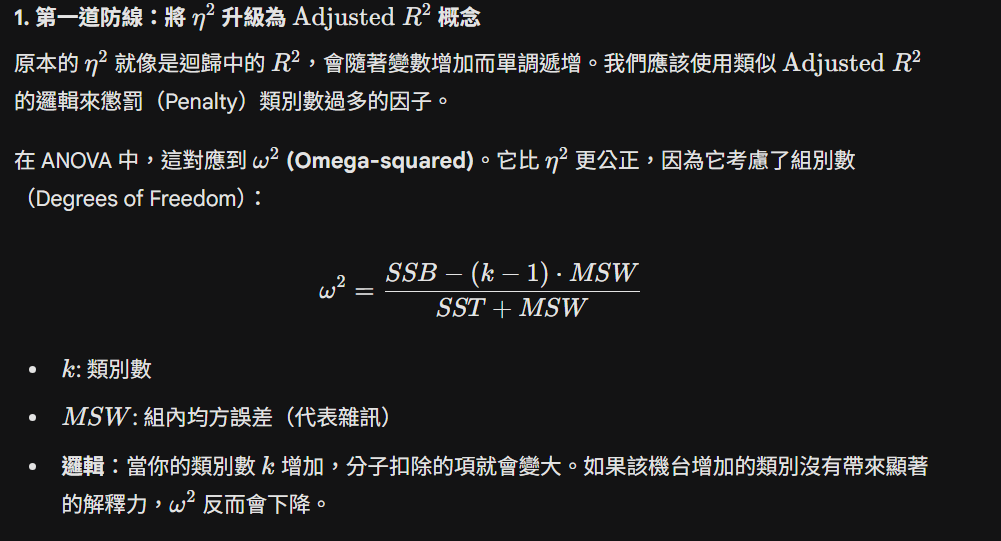

### **(Omega-squared) 是什麼？**

$\omega^2$ 是一種衡量**效應值 (Effect Size)** 的統計指標，主要用於方差分析 (ANOVA)。它告訴我們：在因變數（例如你的測量值 $y$）的所有變異中，有多大比例是由自變數（例如機台因子）產生的。簡單來說，它回答了：「這個機台對結果的影響力到底有多大？」

簡單來說，它回答了：**「這個機台對結果的影響力到底有多大？」**

---

### **1. 為什麼要用 $\omega^2$？（與 $\eta^2$ 的對比)**

在描述性統計中，我們常用 $\eta^2$ (Eta-squared)，它的計算方式與 $R^2$ 相同：
$$\eta^2 = \frac{SS_{between}}{SS_{total}}$$

**但 $\eta^2$  有一個嚴重的缺點：它會「高估」影響力。**
特別是當你的樣本數較小，或者**類別數量（例如機台數）很多**時，$\eta^2$  會因為捕捉到了隨機誤差而顯得虛高。這就是你之前觀察到「類別越多、相關性越高」的原因之一。

**$\omega^2$ 則是 $\eta^2$ 的「無偏修正式**」：
它在計算中扣除了組內隨機誤差的影響，因此被認為是比 $\eta^2$ 更精準、更保守的指標。

---

### **2. 數學來源與公式**

 最初由統計學家 **William Hays** 於 1963 年在他的著作 *Statistics for the Social Sciences* 中推廣。其設計邏輯是基於「總體（Population）」的變異估計，而非僅僅是手邊這份「樣本」的變異。

其標準公式為：

$$\omega^2 = \frac{SS_{between} - (k - 1)MS_{within}}{SS_{total} + MS_{within}}$$

* **$SS_{between}$: **: 組間平方和（機台造成的變異）。
* **$k - 1$**: 自由度（機台類別數 - 1）。
* **$MS_{within}$**: 組內均方誤差（隨機雜訊）。
* **$SS_{total}$**: 總平方和。

**公式背後的直覺：**
你看分子部分：$SS_{between} - (k - 1)MS_{within}$。這代表我們**主動扣掉了由類別數量帶來的隨機噪音**。如果類別很多 ($k$ 大) 但帶來的解釋力不夠強，分子會變得很小甚至為 0。這就是它能公平對待「2 類別」與「100 類別」因子的原因。

---

### **3. 如何解讀  的數值？**

根據統計學家 Cohen (1988) 的建議， 的影響力強度標準如下：

|  數值 | 影響力程度 (Effect Size) | 實務意義 |
| --- | --- | --- |
| **0.01 左右** | **小 (Small)** | 該機台有影響，但不是主因。 |
| **0.06 左右** | **中 (Medium)** | 該機台是值得注意的變異來源。 |
| **0.14 以上** | **大 (Large)** | **根本原因 (Root Cause)**，必須優先處理。 |

---

### **總結**

在你的機台分析中，使用  $\omega^2$ 而不是 $\eta^2$ 是非常專業的選擇：

1. **來源**：它是從 ANOVA 的方差成分估計理論演變而來。
2. **核心優勢**：它能**自動懲罰類別過多**的欄位，防止那些「碎類別」機台靠著隨機波動霸佔排名。
3. **適用性**：當你需要比較「只有 2 個類別的機台」與「有 20 個類別的機台」時， 提供了最公平的競爭平台。

你要不要試著在你目前的資料上同時計算  與 ，看看那些 100 類別的機台排名會發生什麼變化？

$\omega^2$ 的特性： 非常保守。在真實製程中，能達到 $0.14$ (Large Effect) 已經是非常強的根因了，鮮少看到超過 $0.5$ 的情況。